## MM

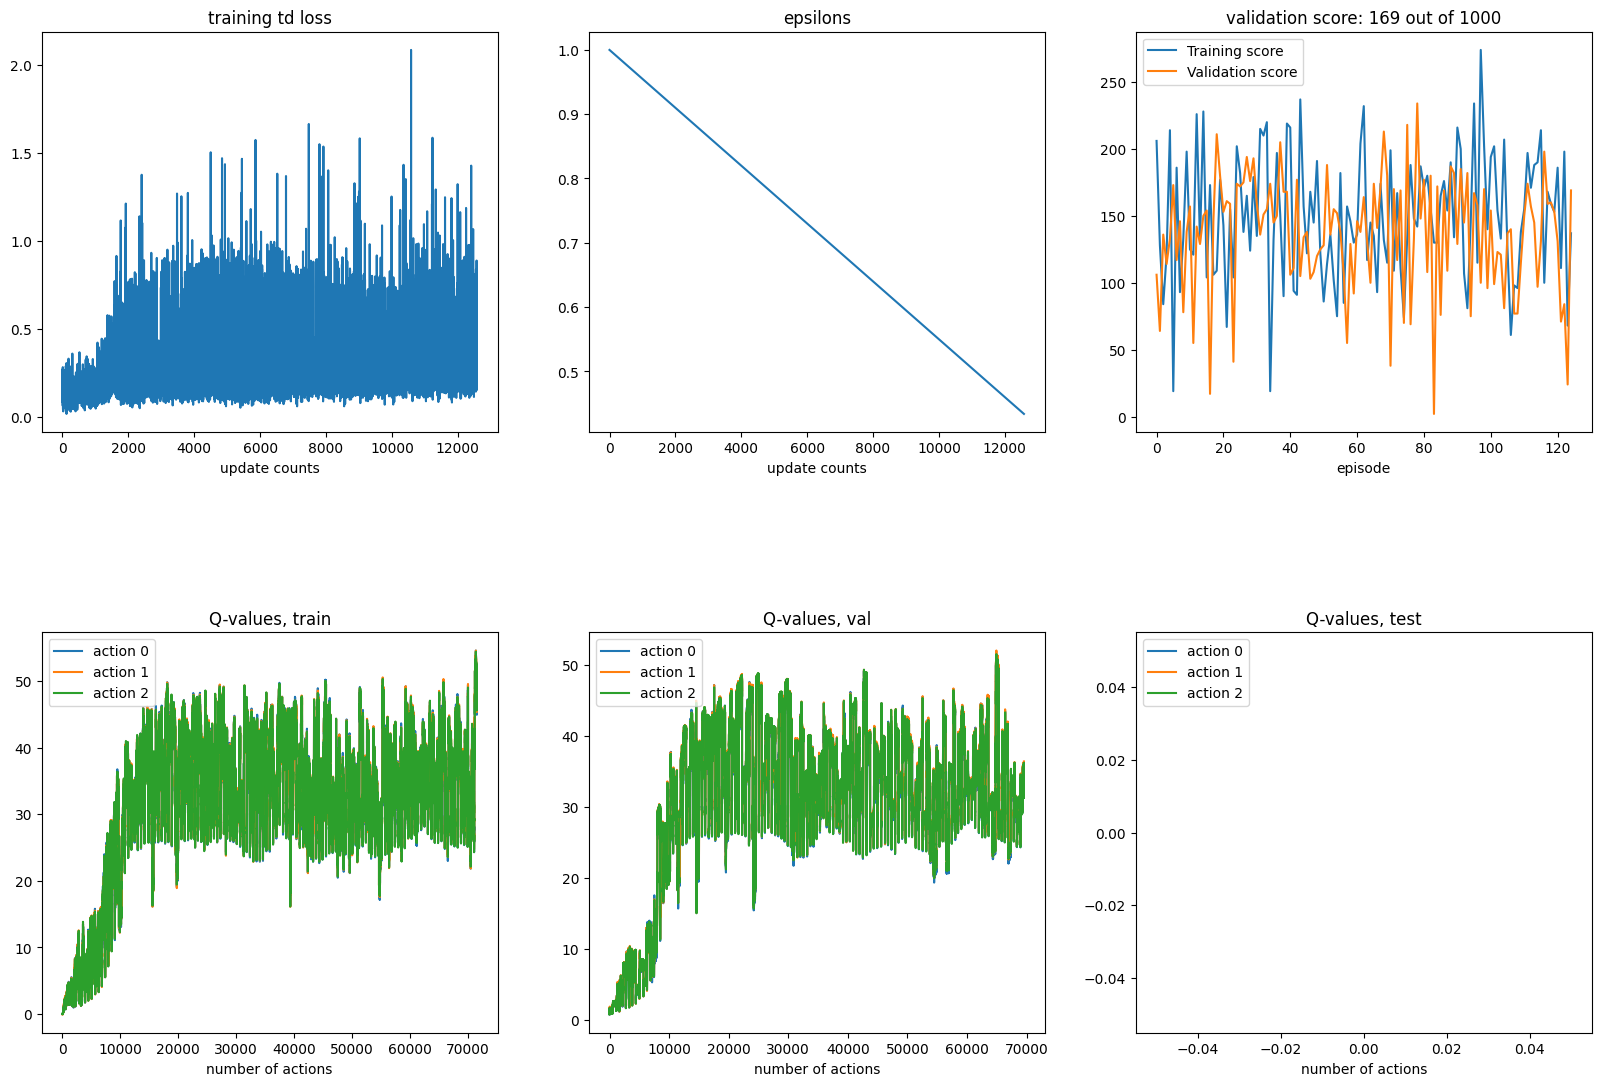

In [1]:
from agent import DQNMMAgent
import logging
from tqdm.auto import tqdm
import random

logger = logging.getLogger()
logger.disabled = True

params_all = []
for test_seed in range(5):
    num_iterations = 100 * 100
    batch_size = 32
    question_interval = 1
    deterministic_objects = True
    room_size = "l"
    capacity = {
        "episodic": 32,
        "episodic_agent": 0,
        "semantic": 32,
        "semantic_map": 0,
        "short": 1,
    }
    terminates_at = 99
    if deterministic_objects:
        root_dir = f"./training-results/deterministic-objects/DQN/"
    else:
        root_dir = f"./training-results/stochastic-objects/DQN/"

    default_root_dir = (
        root_dir
        + f"mm/{room_size}/{terminates_at+1}-question_interval={question_interval}"
    )

    params = {
        "env_str": "room_env:RoomEnv-v2",
        "num_iterations": num_iterations,
        "replay_buffer_size": num_iterations,
        "warm_start": num_iterations // 10,
        "batch_size": batch_size,
        "target_update_interval": 10,
        "epsilon_decay_until": num_iterations,
        "max_epsilon": 1.0,
        "min_epsilon": 0.1,
        "gamma": 0.99,
        "capacity": capacity,
        "pretrain_semantic": False,
        "nn_params": {
            "hidden_size": 64,
            "num_layers": 2,
            "embedding_dim": 64,
            "make_categorical_embeddings": False,
            "memory_of_interest": [
                "episodic",
                "semantic",
                "short",
            ],
            "fuse_information": "sum",
            "include_positional_encoding": True,
            "max_timesteps": 100,
            "max_strength": 100,
        },
        "run_test": True,
        "num_samples_for_results": 10,
        "plotting_interval": 10,
        "train_seed": test_seed + 5,
        "test_seed": test_seed,
        "device": "cpu",
        "qa_policy": "episodic_semantic",
        "explore_policy": "avoid_walls",
        "env_config": {
            "question_prob": 1.0,
            "terminates_at": 99,
            "randomize_observations": "objects",
            "room_size": room_size,
            "rewards": {"correct": 1, "wrong": 0, "partial": 0},
            "make_everything_static": False,
            "num_total_questions": 1000,
            "question_interval": question_interval,
            "include_walls_in_observations": True,
            "deterministic_objects": deterministic_objects,
        },
        "ddqn": True,
        "dueling_dqn": False,
        "default_root_dir": default_root_dir,
        "run_handcrafted_baselines": False,
    }
    params_all.append(params)

for params in tqdm(params_all):
    agent = DQNMMAgent(**params)
    agent.train()

## Explore

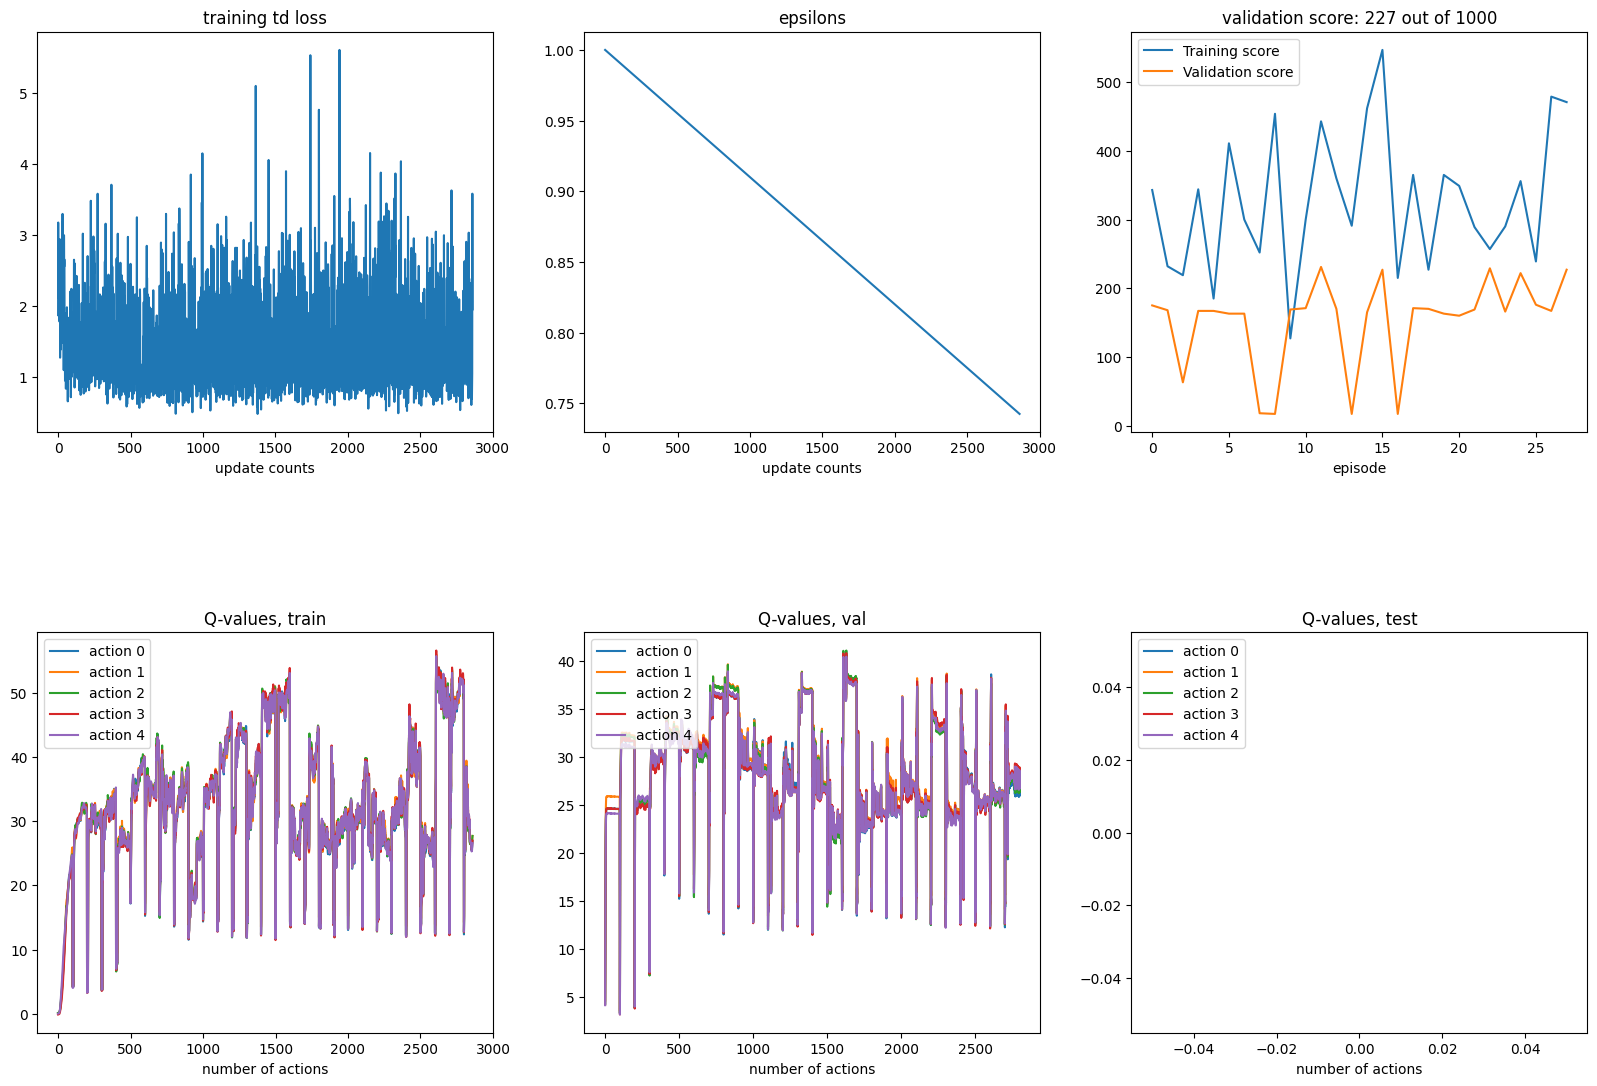

In [1]:
from agent import DQNExploreAgent
import logging
from tqdm.auto import tqdm
import random

logger = logging.getLogger()
logger.disabled = True

params_all = []
for test_seed in range(5):
    num_iterations = 100 * 100
    batch_size = 32
    question_interval = 1
    deterministic_objects = True
    room_size = "l"
    capacity = {
        "episodic": 32,
        "episodic_agent": 0,
        "semantic": 32,
        "semantic_map": 0,
        "short": 1,
    }
    terminates_at = 99

    if deterministic_objects:
        root_dir = f"./training-results/deterministic-objects/DQN/"
    else:
        root_dir = f"./training-results/stochastic-objects/DQN/"

    default_root_dir = (
        root_dir
        + f"explore/{room_size}/{terminates_at+1}-question_interval={question_interval}"
    )

    params = {
        "env_str": "room_env:RoomEnv-v2",
        "num_iterations": num_iterations,
        "replay_buffer_size": num_iterations,
        "warm_start": num_iterations // 10,
        "batch_size": batch_size,
        "target_update_interval": 10,
        "epsilon_decay_until": num_iterations,
        "max_epsilon": 1.0,
        "min_epsilon": 0.1,
        "gamma": 0.9,
        "capacity": capacity,
        "pretrain_semantic": False,
        "nn_params": {
            "hidden_size": 64,
            "num_layers": 2,
            "embedding_dim": 64,
            "make_categorical_embeddings": False,
            "memory_of_interest": [
                "episodic",
                "semantic",
                "short",
            ],
            "fuse_information": "sum",
            "include_positional_encoding": True,
            "max_timesteps": 100,
            "max_strength": 100,
        },
        "run_test": True,
        "num_samples_for_results": 10,
        "train_seed": test_seed + 5,
        "test_seed": test_seed,
        "device": "cpu",
        "mm_policy": "neural",
        "mm_agent_path": "./training-results/deterministic-objects/DQN/mm/l/100-question_interval=1/2024-04-05 22:34:41.366362/agent.pkl",
        "qa_policy": "episodic_semantic",
        "env_config": {
            "question_prob": 1.0,
            "terminates_at": 99,
            "randomize_observations": "objects",
            "room_size": room_size,
            "rewards": {"correct": 1, "wrong": 0, "partial": 0},
            "make_everything_static": False,
            "num_total_questions": 1000,
            "question_interval": question_interval,
            "include_walls_in_observations": True,
            "deterministic_objects": deterministic_objects,
        },
        "ddqn": True,
        "dueling_dqn": False,
        "default_root_dir": default_root_dir,
        "run_neural_baseline": True,
    }
    params_all.append(params)

for params in tqdm(params_all):
    agent = DQNExploreAgent(**params)
    agent.train()

## DQN baselines LSTM 

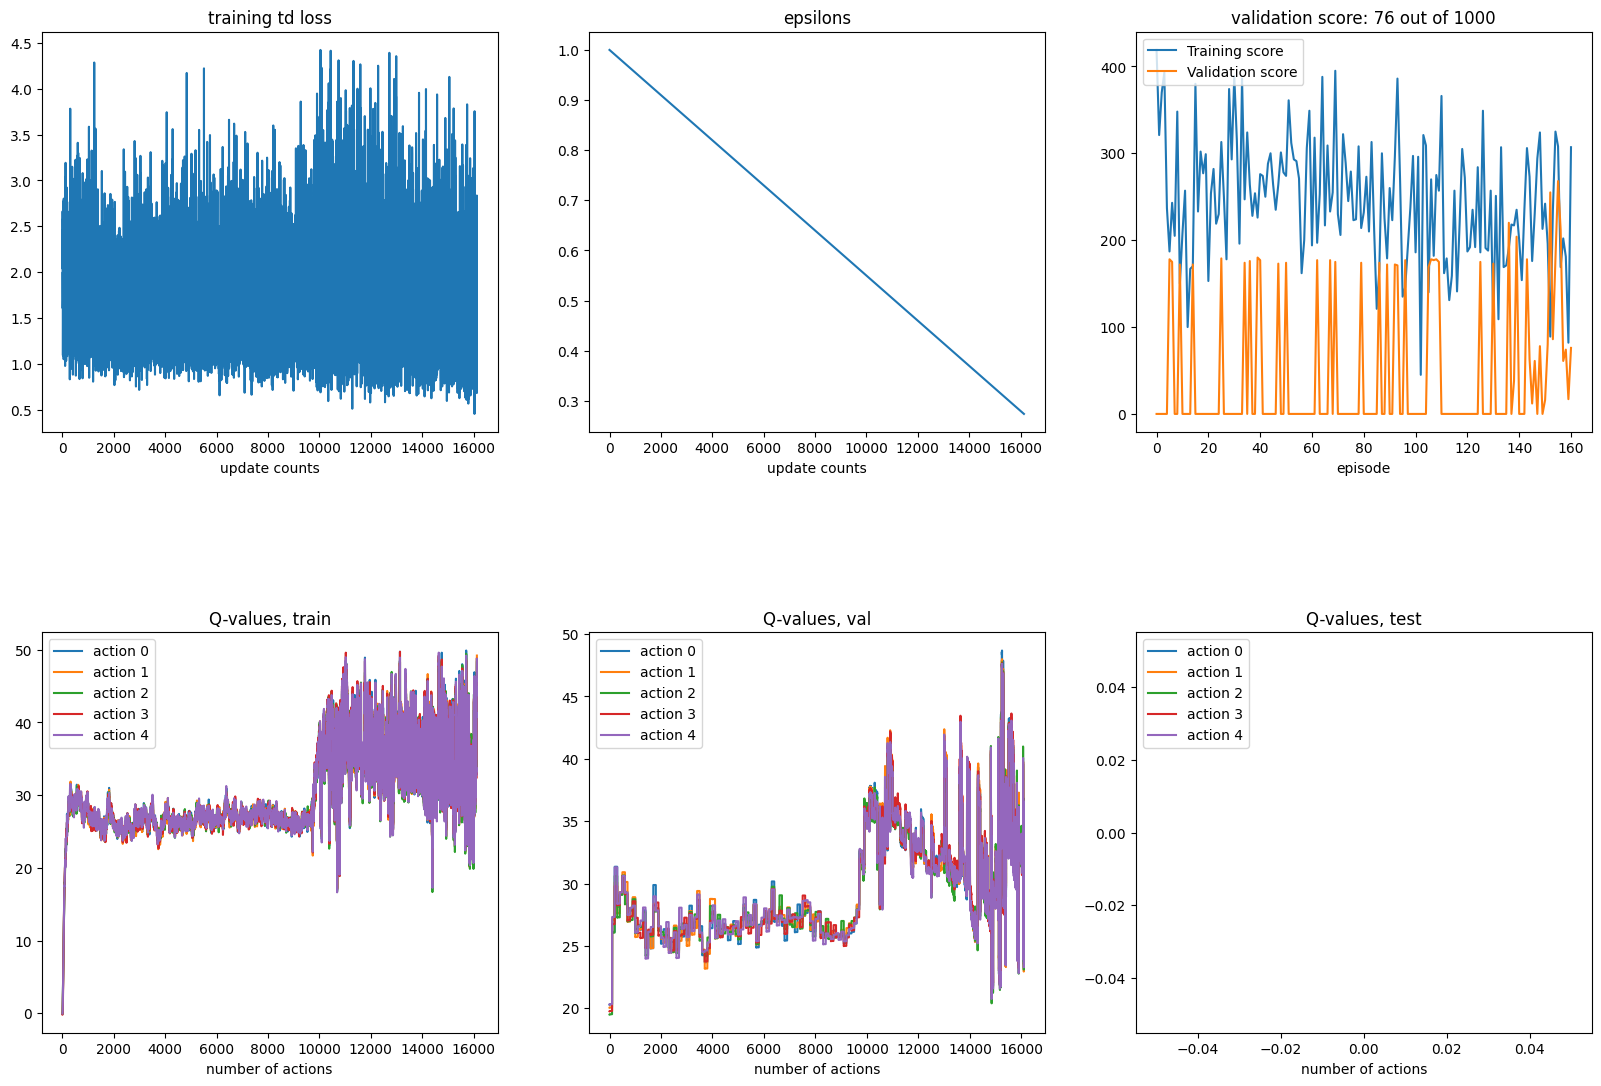

In [1]:
from agent import DQNLSTMBaselineAgent
import logging
from tqdm.auto import tqdm
import random

logger = logging.getLogger()
logger.disabled = True

params_all = []
for test_seed in range(5):
    for history_block_size in [1, 6, 12, 24, 48, 100]:

        num_iterations = 100 * 200
        batch_size = 32
        question_interval = 1
        deterministic_objects = True
        room_size = "l"
        terminates_at = 99

        if deterministic_objects:
            root_dir = f"./training-results/deterministic-objects/DQN/"
        else:
            root_dir = f"./training-results/stochastic-objects/DQN/"

        default_root_dir = (
            root_dir
            + f"baselines/{room_size}/{terminates_at+1}-question_interval={question_interval}/history_block_size={history_block_size}"
        )

        params = {
            "env_str": "room_env:RoomEnv-v2",
            "num_iterations": num_iterations,
            "replay_buffer_size": num_iterations,
            "warm_start": num_iterations // 10,
            "batch_size": batch_size,
            "target_update_interval": 10,
            "epsilon_decay_until": num_iterations,
            "max_epsilon": 1.0,
            "min_epsilon": 0.1,
            "gamma": 0.9,
            "history_block_size": history_block_size,
            "nn_params": {
                "hidden_size": 128,
                "num_layers": 2,
                "embedding_dim": 128,
                "fuse_information": "sum",
                "include_positional_encoding": True,
                "max_timesteps": 100,
                "max_strength": 100,
            },
            "run_test": True,
            "num_samples_for_results": 10,
            "train_seed": test_seed + 5,
            "test_seed": test_seed,
            "device": "cpu",
            "env_config": {
                "question_prob": 1.0,
                "terminates_at": 99,
                "randomize_observations": "objects",
                "room_size": room_size,
                "rewards": {"correct": 1, "wrong": 0, "partial": 0},
                "make_everything_static": False,
                "num_total_questions": 1000,
                "question_interval": question_interval,
                "include_walls_in_observations": True,
                "deterministic_objects": deterministic_objects,
            },
            "ddqn": True,
            "dueling_dqn": False,
            "default_root_dir": default_root_dir,
            "run_handcrafted_baselines": True,
        }
        params_all.append(params)

for params in tqdm(params_all):
    agent = DQNLSTMBaselineAgent(**params)
    agent.train()